In [48]:
import re
import string

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Data Preperation

In [10]:
data = pd.read_csv('./dataset/train.tsv', sep='\t')
test_data = pd.read_csv('./dataset/test.tsv', sep='\t')

In [11]:
data.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [12]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [13]:
data["title"] = data["title"].apply(wordopt)

In [14]:
features = data["title"]
target = data["is_fake"]
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.15)

In [15]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

# Model Selection

In [66]:
model_classes = [
    (LogisticRegression, {'penalty': ['l2', 'l1', None]}), 
    (DecisionTreeClassifier, {'min_samples_split':[2,3,4], 'min_samples_leaf':[1,2,3]}), 
    (GradientBoostingClassifier, {}),
    (RandomForestClassifier, {'n_estimators':[100,200,250]}),
    (PassiveAggressiveClassifier, {}),
    (MultinomialNB, {'alpha':[0.2,0.5,0.7,1]}),
    (SVC, {'kernel':['linear', 'poly', 'rbf', 'sigmoid']}),
    (MLPClassifier, { 'solver': ['adam'],'max_iter': [250,300],'hidden_layer_sizes': [(128,64,32), (256,128,64,32)], 
                      'alpha': 10.0 ** -np.arange(7,10)})
]

best_models = []
model_scores = []
model_params = []
for model_cls, params in model_classes: 
    print('Model: ', model_cls.__name__)
    model = model_cls()
    if len(params) != 0:
        best_model = GridSearchCV(model, params).fit(xv_train, y_train)
        best_params = model.get_params()
        print('Best params:', best_params)
    else:
        best_model = model.fit(xv_train, y_train)
        best_params = {}
        model_params.append(best_params)

    y_pred = best_model.predict(xv_test)
    print(classification_report(y_test, y_pred))
    model_scores.append(f1_score(y_test, y_pred))

    best_models.append(best_model)

Model:  LogisticRegression


C:\Users\VLADISLAV RYZHOV\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\VLADISLAV RYZHOV\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\VLADISLAV RYZHOV\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\VLADISLAV RYZHOV\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\VLADISLAV RYZHOV

Best params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       419
           1       0.83      0.84      0.84       445

    accuracy                           0.83       864
   macro avg       0.83      0.83      0.83       864
weighted avg       0.83      0.83      0.83       864

Model:  DecisionTreeClassifier
Best params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
              precision    recal

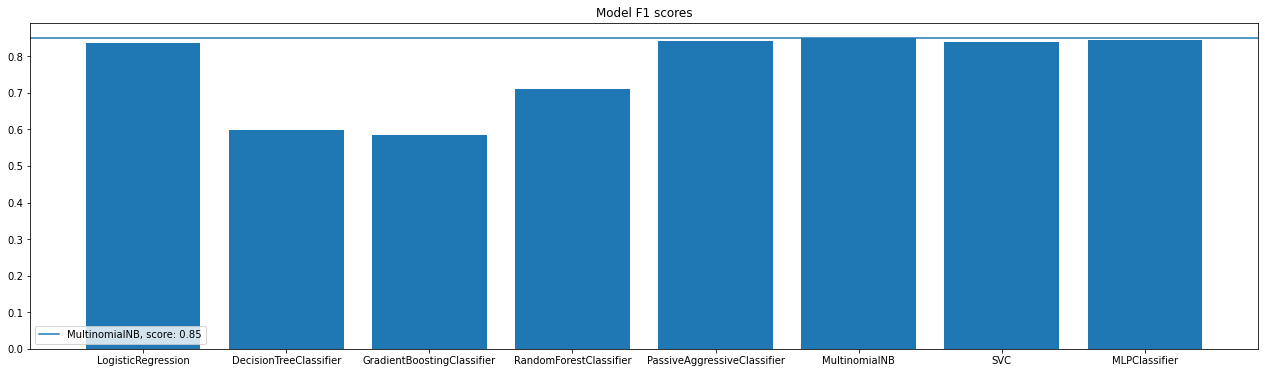

In [67]:
model_names = [model.__name__ for model, _ in model_classes]
best_model_index = np.argsort(model_scores)[-1]
best_model_name, best_model_score = model_names[best_model_index], model_scores[best_model_index]

plt.figure(figsize=(22, 6))
plt.title("Model F1 scores")
plt.bar(
    x=model_names,
    height=model_scores
)
plt.axhline(best_model_score, label=f"{best_model_name}, score: {round(best_model_score, 2)}")
plt.legend()

# Test models by keyboard news

In [68]:
label_mapping = ["Fake News", "Not Fake News"]
    
def test_models(text: str):
    # Vectorize news text
    text = wordopt(text)
    new_xv_test = vectorization.transform([text])

    # Get predictions
    for model_name, best_model in zip(model_names, best_models):
        prediction = best_model.predict(new_xv_test)
        print(f"Model {model_name} | Prediction: {label_mapping[prediction[0]]}")

In [69]:
news = str(input())
test_models(news)

Компания Контур - профессионалы своего дела
Model LogisticRegression | Prediction: Not Fake News
Model DecisionTreeClassifier | Prediction: Fake News
Model GradientBoostingClassifier | Prediction: Fake News
Model RandomForestClassifier | Prediction: Fake News
Model PassiveAggressiveClassifier | Prediction: Not Fake News
Model MultinomialNB | Prediction: Not Fake News
Model SVC | Prediction: Fake News
Model MLPClassifier | Prediction: Not Fake News
